## EDAコードの完コピ(2)
* https://www.kaggle.com/code/ambrosm/amex-eda-which-makes-sense

In [1]:
import pandas as pd
import numpy as np
import pickle, gc, os
from matplotlib import pyplot as plt

DATA = "/mnt/sdb/KAGGLE_DATA/amex-default-prediction"
PICKLE = "_pickle"

In [2]:
from colorama import Fore
y_ = Fore.YELLOW
g_ = Fore.GREEN
b_ = Fore.BLUE
sr_ = Fore.RESET

## trainの正解ラベルの分布確認
[insight]
* 二値分類でクラスは均等じゃない => Stratified KFoldが良い
* 均等じゃないので、Accuracyは良くない（competition metricはAUCとrecallのmixed metric)
* train内に正解ラベルの欠損はない
* Customer IDの重複もない

In [3]:
train_labels = pd.read_csv(os.path.join(DATA, "train_labels.csv"))
display(train_labels.head(2))

,customer_ID,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0


In [4]:
print(f"Train Labels isna() : {train_labels.isna().any().any()}")
print(f"Train_Labels_ID duplicated : {train_labels.customer_ID.duplicated().any()}")

Train Labels isna() : False
Train_Labels_ID duplicated : False


#### unsampled : サブサンプル前の比率も確認している
* dataの項 : Note that the negative class has been subsampled for this dataset at 5%, <br>
            and thus receives a 20x weightning in the scoring metric => 負例は20倍多く換算されている
            

In [5]:
label_stats = pd.DataFrame(
    {
        "absolute": train_labels.target.value_counts(),
        "relative": train_labels.target.value_counts()/len(train_labels)
    })
label_stats["absolute unsampled"] = label_stats.absolute * np.array([20, 1])
label_stats["relative unsampled"] = label_stats["absolute unsampled"] / label_stats["absolute unsampled"].sum()
display(label_stats)

,absolute,relative,absolute unsampled,relative unsampled
0,340085,0.741066,6801700,0.98283
1,118828,0.258934,118828,0.01717


## データ読み込み
* float64はメモリがヤバイので適宜float32, float16を使う
* pickleではなくfeatherを使ってる（バイナリで保存するから読み込みが早いらしい)

[insight]
* trainとtestで時系列が大きく異なるが、世情を加味するモデルは存在しない？

In [6]:
train = pd.read_pickle(os.path.join(DATA, PICKLE, "train_data.pkl"))
test = pd.read_pickle(os.path.join(DATA, PICKLE, "test_data.pkl"))

train = pd.merge(train, train_labels, on="customer_ID", how="left")

In [7]:
with pd.option_context("display.min_rows", 6):
    display(train)
    display(test)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,...,NaN,NaN,0.002427,0.003706,0.003818,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,0.002714,...,NaN,NaN,0.003954,0.003167,0.005032,NaN,0.009576,0.005492,0.009217,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,0.091505,0.021655,1.009672,0.006815,0.123977,0.007598,0.009423,...,NaN,NaN,0.003269,0.007329,0.000427,NaN,0.003429,0.006986,0.002603,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5531448,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-01-06,0.983019,0.443984,0.013151,0.815422,0.003457,0.100503,0.002111,0.012343,...,NaN,NaN,0.009955,0.009994,0.001088,NaN,0.005693,0.006773,0.005566,0
5531449,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-02-06,0.969861,0.442553,0.009855,1.003541,0.005117,0.101802,0.009930,0.008578,...,NaN,NaN,0.005541,0.006564,0.009883,NaN,0.008123,0.001168,0.003983,0
5531450,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-03-14,0.982175,0.002474,0.000077,0.992880,0.000809,0.119165,0.003287,0.014092,...,NaN,NaN,0.007316,0.002888,0.006207,NaN,0.005110,0.003184,0.001914,0


,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-02-19,0.631315,0.001912,0.010728,0.814497,0.007547,0.168651,0.009971,0.002347,...,NaN,NaN,NaN,NaN,0.004669,NaN,NaN,NaN,0.008281,NaN
1,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-03-25,0.587042,0.005275,0.011026,0.810848,0.001817,0.241389,0.000166,0.009132,...,NaN,NaN,NaN,0.000142,0.004940,0.009021,NaN,0.003695,0.003753,0.001460
2,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-04-25,0.609056,0.003326,0.016390,1.004620,0.000114,0.266976,0.004196,0.004192,...,NaN,NaN,NaN,0.000074,0.002114,0.004656,NaN,0.003155,0.002156,0.006482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21518,fffffa7cf7e453e1acc6a1426475d5cb9400859f82ff61...,2019-02-17,0.460082,0.005246,0.004420,0.818864,0.000665,NaN,0.000559,0.007058,...,NaN,NaN,NaN,0.007798,0.007739,0.008192,NaN,0.009386,0.003594,0.005603
21519,fffffa7cf7e453e1acc6a1426475d5cb9400859f82ff61...,2019-03-19,0.460331,0.002663,0.009529,0.816313,0.009027,NaN,0.008527,0.006851,...,NaN,NaN,NaN,0.007196,0.008456,0.004774,NaN,0.006198,0.005605,0.005972
21520,fffffa7cf7e453e1acc6a1426475d5cb9400859f82ff61...,2019-04-18,0.454546,0.004400,0.000346,0.810128,0.008738,NaN,0.000936,0.003494,...,NaN,NaN,NaN,0.003400,0.009588,0.006189,NaN,0.007675,0.006442,0.003142


In [8]:
# S_2のレンジの確認 --
print(f"{g_}Train statement dates: ", train.S_2.min(), "---", train.S_2.max(), " // isna :", train.S_2.isna().any())
print(f"{g_}Test  statement dates: ", test.S_2.min(), "---", test.S_2.max(), " // isna :", test.S_2.isna().any())

Train statement dates:  2017-03-01 --- 2018-03-31  // isna : False
Test  statement dates:  2018-04-01 --- 2019-10-31  // isna : False


### memory usageを先に確認しておく

In [9]:
# memory usage --
print(f"{g_}Train data memory usage: {train.memory_usage().sum() / 1e9} GBytes{sr_}")
print(f"{g_}Test  data memory usage: {test.memory_usage().sum() / 1e9}  GBytes{sr_}")

Train data memory usage: 8.496308736 GBytes
Test  data memory usage: 17.363828336  GBytes


### 欠損値の確認

[insight]
* 列・行ともに欠損がかなりあるので、欠損列・行をドロップして進めるのは得策でない => 決定木系が有効かも(というより楽)

In [10]:
train.info(max_cols=200, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5531451 entries, 0 to 5531450
Data columns (total 191 columns):
 #    Column       Non-Null Count    Dtype  
---   ------       --------------    -----  
 0    customer_ID  5531451 non-null  object 
 1    S_2          5531451 non-null  object 
 2    P_2          5485466 non-null  float64
 3    D_39         5531451 non-null  float64
 4    B_1          5531451 non-null  float64
 5    B_2          5529435 non-null  float64
 6    R_1          5531451 non-null  float64
 7    S_3          4510907 non-null  float64
 8    D_41         5529435 non-null  float64
 9    B_3          5529435 non-null  float64
 10   D_42         791314 non-null   float64
 11   D_43         3873055 non-null  float64
 12   D_44         5257132 non-null  float64
 13   B_4          5531451 non-null  float64
 14   D_45         5529434 non-null  float64
 15   B_5          5531451 non-null  float64
 16   R_2          5531451 non-null  float64
 17   D_46         4319752 non-

### customer_ID 1つあたりstatementがいくつくらい存在するか
[insight]
* 切り捨てない場合、customer_IDあたりのstatement数が変わっても対応できるモデルが必要

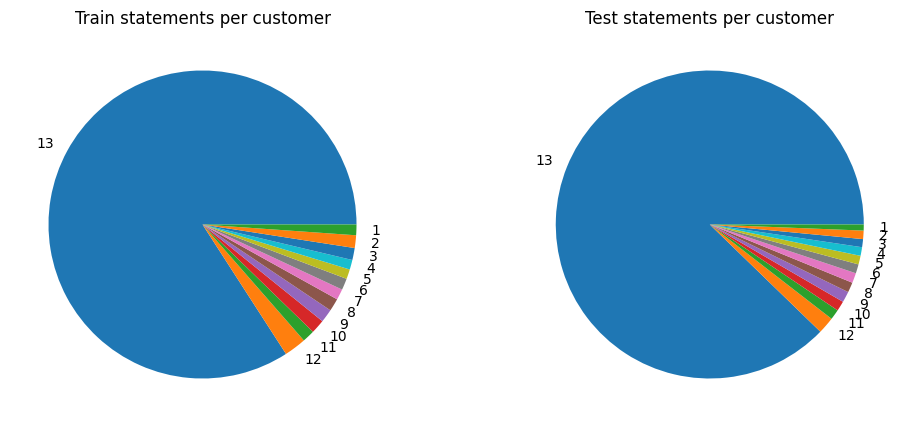

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
train_sc = train.customer_ID.value_counts().value_counts().sort_index(ascending=False).rename("Train statements per customer")
ax1.pie(train_sc, labels=train_sc.index)

test_sc = test.customer_ID.value_counts().value_counts().sort_index(ascending=False).rename("Test statements per customer")
ax2.pie(test_sc, labels=test_sc.index)

ax1.set_title(train_sc.name)
ax2.set_title(test_sc.name)
plt.show()

### 最後のstatementを受け取った日時を可視化
[insight]
* trainのlast statementは2018/3のみなので、TimeSeriesSplitでのCVは無理そう --

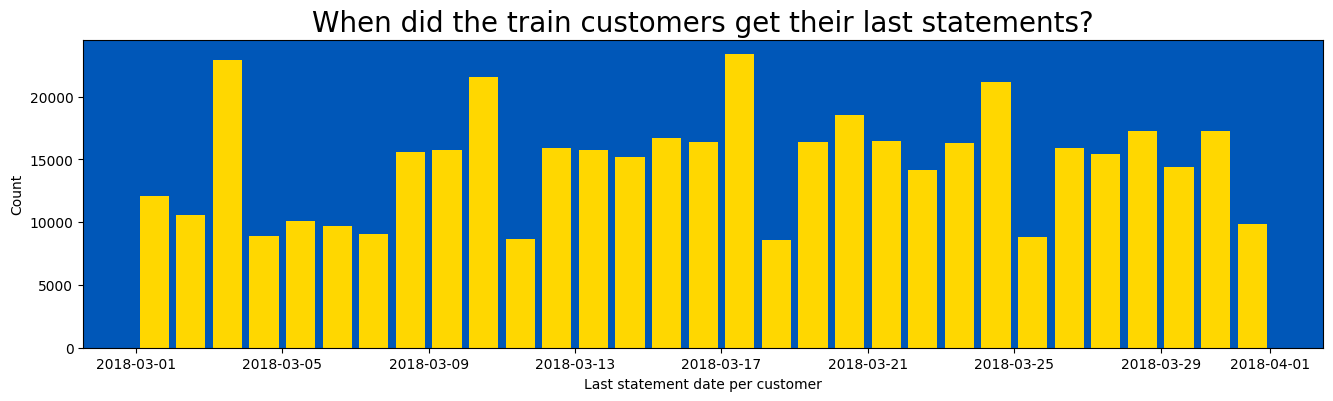

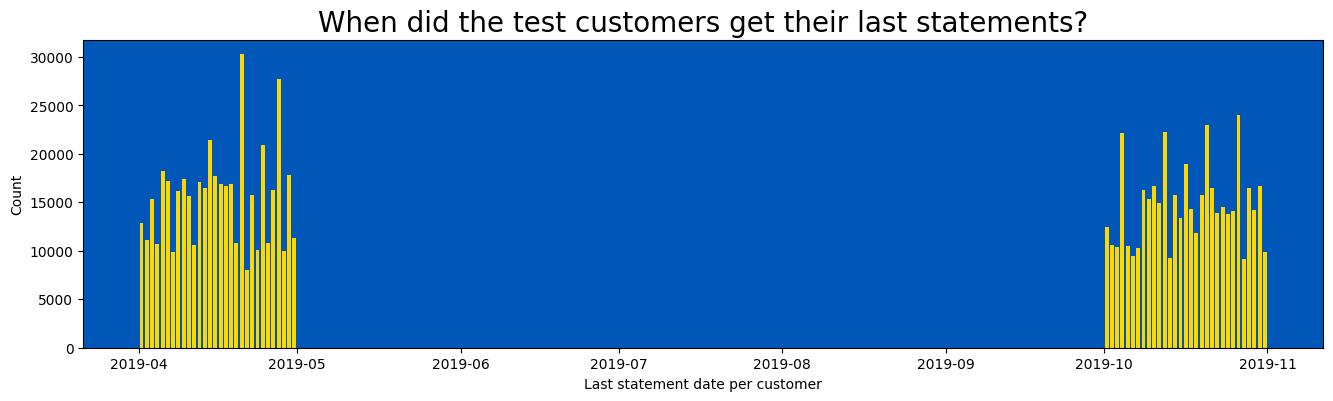

In [21]:
temp = pd.to_datetime(train.S_2).groupby(train.customer_ID).max()
plt.figure(figsize=(16, 4))
plt.hist(
    temp, bins=pd.date_range("2018-03-01", "2018-04-01", freq="d"),
    rwidth=0.8, color="#ffd700"
)
plt.title("When did the train customers get their last statements?", fontsize=20)
plt.xlabel("Last statement date per customer")
plt.ylabel("Count")
plt.gca().set_facecolor("#0057b8")
plt.show()
del temp

temp = pd.to_datetime(test.S_2).groupby(test.customer_ID).max()
plt.figure(figsize=(16, 4))
plt.hist(
    temp, bins=pd.date_range("2019-04-01", "2019-11-01", freq="d"),
    rwidth=0.74, color="#ffd700"
)
plt.title("When did the test customers get their last statements?", fontsize=20)
plt.xlabel("Last statement date per customer")
plt.ylabel("Count")
plt.gca().set_facecolor("#0057b8")
plt.show()
del temp


### 最後のstatement ~ 最初のstatementの日数 --